In [1]:
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(12,8)

In [2]:
import numpy as npa # to avoid interfering with Pennylane numpy
# npa.__version__
# '1.20.0'
from numpy.random import default_rng
# rng = default_rng(seed) # seed for reproducibility

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit import BasicAer #, Aer  ## BasicAer in python - Aer in C++
from qiskit.circuit import Parameter
# from qiskit.aqua.operators.gradients import Gradient, NaturalGradient#, QFI, Hessian

# backend = Aer.get_backend('unitary_simulator')
# backend = Aer.get_backend('statevector_simulator')
from qiskit.providers.aer import StatevectorSimulator
backend = StatevectorSimulator(zero_threshold=1e-6)

from qiskit.visualization import plot_bloch_multivector
# from qiskit_textbook.widgets import plot_bloch_vector_spherical

## State preparation with qiskit

### General rotation - arbitrary pure state on Bloch sphere

{Parameter(θ), Parameter(ϕ), Parameter(λ)}


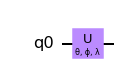

In [4]:
theta = Parameter('θ')
phi = Parameter('ϕ')
lam = Parameter('λ')
backend = StatevectorSimulator(zero_threshold=1e-6)
q = QuantumRegister(1)
qc = QuantumCircuit(q)
params = (theta, phi, lam)
qc.u(*params,q)
print(qc.parameters)
qc.draw('mpl')

In [5]:
# function creating a circuit that rotates the initial |0> state to any pure state with general rotation gate U((θ, ϕ, λ) 
def qc_general(theta, phi, lam, q):
    qc = QuantumCircuit(q)
    qc.u(theta, phi, lam,q)
    return qc

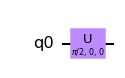

In [6]:
##unit test
params = (pi/2, 0, 0) # |+>
test_qc = qc_general(*params, q)
test_qc.draw('mpl')

In [7]:
job = execute(test_qc, backend)
# job.result().get_unitary(qc, decimals=2)
result = job.result()
outputstate = result.get_statevector(test_qc, decimals=3)
print(outputstate)

[0.70710678+0.j 0.70710678+0.j]


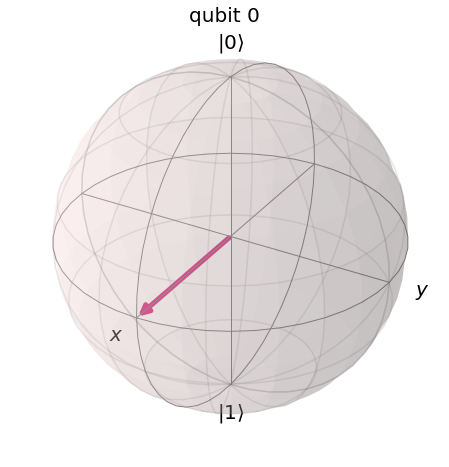

In [8]:
plot_bloch_multivector(outputstate)

### Random pure states in a region of the sphere surface

> Quantum cats: north hemisphere (around |+>)

> Quantum dogs: south hemisphere (around |+i>)

In [9]:
def random_qstates(theta_min, theta_max, phi_min, phi_max, qreg, rng_seed=None, size=10):
    '''
    Creates a list of random pure state vectors starting from initial state |0> 
    applying general rotation U3(θ, ϕ, λ) with angles drawn from a uniform distribution
    with some restricted range [a,b] obtained with (b - a) * random() + a
    '''
    ## pick parameters at random
    rng = default_rng(rng_seed)
    params = (theta, phi, lam, qreg)
    state = []
    θ_vals, ϕ_vals, λ_vals = [], [], []
    x, y, z = [], [], []

    for i in range(size):
        θ = rng.random()*(theta_max-theta_min)+theta_min
        ϕ = rng.random()*(phi_max-phi_min)+phi_min
        λ = rng.random()*2*pi

        x.append(npa.sin(θ)*npa.cos(ϕ))
        y.append(npa.sin(θ)*npa.sin(ϕ))
        z.append(npa.cos(θ))
        coords = [c for c in zip(x, y, z)]
        
        θ_vals.append(θ)
        ϕ_vals.append(ϕ)
        λ_vals.append(λ)
        angles = [a for a in zip(θ_vals, ϕ_vals, λ_vals)]
        
        random_qc = qc_general(*params).bind_parameters({theta: θ, phi: ϕ, lam: λ})
        job = execute(random_qc, backend)
        result = job.result()
        outputstate = result.get_statevector(random_qc, decimals=3)
        state.append(outputstate)
    return state, coords, angles

In [27]:
random_qstates(theta_min=pi/8, theta_max=3*pi/8, phi_min=3*pi/8, phi_max=pi/2, qreg=q, rng_seed=123, size=2)

([array([0.89413144+0.j        , 0.16258567+0.41724677j]),
  array([0.96410298+0.j        , 0.08443854+0.25174507j])],
 [(0.29074591788492166, 0.7461469117450178, 0.5989420650836165),
  (0.16281490279314662, 0.4854163405239241, 0.8589891057404745)],
 [(0.9286169818846428, 1.199232709755895, 1.3845619148968347),
  (0.5375043632037213, 1.2471753309176505, 5.1025402722608115)])

In [32]:
state, coords, angles = random_qstates(theta_min=pi / 8,
                                       theta_max=3 * pi / 8,
                                       phi_min=3 * pi / 8,
                                       phi_max=pi / 2,
                                       qreg=q,
                                       rng_seed=123,
                                       size=2)
print(state)
print(coords)
print(angles)

[array([0.89413144+0.j        , 0.16258567+0.41724677j]), array([0.96410298+0.j        , 0.08443854+0.25174507j])]
[(0.29074591788492166, 0.7461469117450178, 0.5989420650836165), (0.16281490279314662, 0.4854163405239241, 0.8589891057404745)]
[(0.9286169818846428, 1.199232709755895, 1.3845619148968347), (0.5375043632037213, 1.2471753309176505, 5.1025402722608115)]


In [34]:
def plot_two_groups_of_qstates(theta_min,
                               theta_max,
                               phi_min,
                               phi_max,
                               qreg,
                               rng_seed=None,
                               size=10):
    # Create a sphere
    r = 1
    phi, theta = npa.mgrid[0.0:pi:100j, 0.0:2.0 * pi:100j]
    xs = r * npa.sin(phi) * npa.cos(theta)
    ys = r * npa.sin(phi) * npa.sin(theta)
    zs = r * npa.cos(phi)

    ## x, y are swapped in the visualization

    ## QCATS as pure states on the Bloch sphere
    qcats, cats_coords, cats_angles = random_qstates(theta_min[0],
                                                     theta_max[0],
                                                     phi_min[0],
                                                     phi_max[0],
                                                     qreg,
                                                     rng_seed[0],
                                                     size=size)
    y0, x0, z0 = [c[0] for c in cats_coords], [c[1] for c in cats_coords
                                               ], [c[2] for c in cats_coords]

    ## QDOGS as pure states on the Bloch sphere
    qdogs, dogs_coords, dogs_angles = random_qstates(theta_min[1],
                                                     theta_max[1],
                                                     phi_min[1],
                                                     phi_max[1],
                                                     qreg,
                                                     rng_seed[1],
                                                     size=size)
    y1, x1, z1 = [c[0] for c in dogs_coords], [c[1] for c in dogs_coords
                                               ], [c[2] for c in dogs_coords]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
    ax.set_xlabel('Y')
    ax.set_ylabel('X')
    ax.set_zlabel('Z')

    ax.set_xlim(-1, 1)
    ax.set_ylim(1, -1)
    ax.set_zlim(-1, 1)

    ax.plot_surface(xs,
                    ys,
                    zs,
                    rstride=1,
                    cstride=1,
                    color='aliceblue',
                    alpha=0.4,
                    linewidth=0)

    # ax.plot(npa.array([0, 0, 0]), npa.array([1.5, 0, 0]))
    ax.quiver(0, 0, 0, 0, 1.4, 0, arrow_length_ratio=.1)
    ax.quiver(0, 0, 0, 1.4, 0, 0, arrow_length_ratio=.1)
    ax.quiver(0, 0, 0, 0, 0, 1.4, arrow_length_ratio=.1)
    ax.scatter(x0, y0, z0, marker='o', c='r')
    ax.scatter(x1, y1, z1, marker='o', c='darkblue')
    plt.show()

    return qcats, qdogs, cats_angles, dogs_angles

<div class="alert alert-block alert-info">
qcats and qdogs are the respective qiskit state vectors
</div>

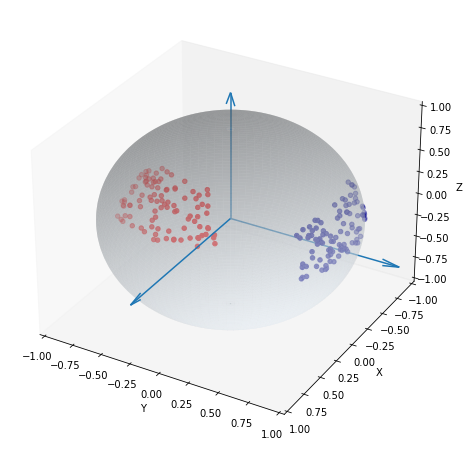

In [35]:
## squeeze = .65
qcats, qdogs, cats_angles, dogs_angles = plot_two_groups_of_qstates(
    theta_min=[pi / 5, pi / 3],
    theta_max=[3 * pi / 5 * squeeze, pi / 2],
    phi_min=[-pi / 5, pi / 3],
    phi_max=[pi / 5 * squeeze, pi * squeeze],
    qreg=q,
    rng_seed=[123, 456],
    size=100)
# qcats are the red points and qdogs are the blue points

<div class="alert alert-block alert-info">

Possible next step:
    draw from a non-uniform distribution with bias to get some overlap
</div>

## State preparation with PennyLane

In [17]:
import pennylane as qml
from pennylane import numpy as np

In [18]:
def simulate_circuit(theta, phi, lam):
    dev = qml.device("default.qubit", wires=1)
    params = (theta, phi, lam)
    @qml.qnode(dev)
    def circuit(theta, phi, lam):
        qml.U3(theta, phi, lam, wires=0)
        return qml.expval(qml.PauliZ(0))
    circuit(*params)
    return dev.state, params

In [44]:
## unit test
params = (pi/2, 0,0) # |+>
state_init, _ = simulate_circuit(*params)
state_init

tensor([0.70710678+0.j, 0.70710678+0.j], requires_grad=True)

In [49]:
## unit test combining angles from previous function
state_ref, _, params = random_qstates(theta_min=pi/8, theta_max=3*pi/8, phi_min=3*pi/8, phi_max=pi/2, qreg=q, rng_seed=123, size=1)
print(params[0])
print(state_ref)
state_init, _ = simulate_circuit(*params[0])
state_init

(0.9286169818846428, 1.199232709755895, 1.3845619148968347)
[array([0.89413144+0.j        , 0.16258567+0.41724677j])]


tensor([0.89413144+0.j        , 0.16258567+0.41724677j], requires_grad=True)

<div class="alert alert-block alert-info">

To generate the states, we only need the angles
</div>

In [54]:
def pet_states(angles):
    pet_states = []
    for a in angles: 
        state, _ = simulate_circuit(*a)
        pet_states.append(state)
    return pet_states

In [56]:
cat_states = pet_states(cats_angles)
cat_states[:5]

[tensor([0.86890622-5.55111512e-17j, 0.41604673-2.68154980e-01j], requires_grad=True),
 tensor([0.93262165+0.j        , 0.32556414-0.15564332j], requires_grad=True),
 tensor([0.83108932+0.j        , 0.52400765-0.18629688j], requires_grad=True),
 tensor([0.83660023+0.j        , 0.5452647 -0.05278691j], requires_grad=True),
 tensor([0.84717264-5.55111512e-17j, 0.48797774-2.10181457e-01j], requires_grad=True)]

In [58]:
dog_states = pet_states(dogs_angles)
dog_states[:5]

[tensor([0.79816156+0.j        , 0.04709576+0.60059979j], requires_grad=True),
 tensor([ 0.75100202-2.77555756e-17j, -0.28385386+5.96173599e-01j], requires_grad=True),
 tensor([ 0.82348682+0.j        , -0.15042074+0.54703112j], requires_grad=True),
 tensor([0.71032145+0.j        , 0.19999501+0.67486698j], requires_grad=True),
 tensor([0.78910384+5.55111512e-17j, 0.12555831+6.01290480e-01j], requires_grad=True)]

In [68]:
npa.savetxt("cats_angles.csv", cats_angles)
npa.savetxt("dogs_angles.csv", dogs_angles)

<div class="alert alert-block alert-info">

To recreate the states, we only need the angles and we use function *simulate_circuit()*
</div>

In [70]:
same_cats = npa.loadtxt("cats_angles.csv")
same_cats[:5]

array([[ 1.03561613, -0.5725209 ,  1.38456191],
       [ 0.73837054, -0.44595238,  5.10254027],
       [ 1.17946556, -0.34158678,  5.15066982],
       [ 1.1594978 , -0.09650894,  1.53915798],
       [ 1.12031049, -0.406705  ,  4.65877489]])

In [71]:
## re-upload the states
simulate_circuit(*same_cats[0])

(tensor([0.86890622-5.55111512e-17j, 0.41604673-2.68154980e-01j], requires_grad=True),
 (1.0356161348592567, -0.572520904016291, 1.3845619148968347))